# Computer Vision using PyTorch

## What is computer vision?
The objective of computer vision is to extract data from images and videos that can mimick the information humans can obtain from the same images. A highly interdisciplinary fields, it draws interest and application purposes from different scientific areas. [(From Wikipedia)](https://en.wikipedia.org/wiki/Computer_vision)


## For what can we use computer vision?
- Image classification (binary or multilevel) 
- Object detection
- Segmentation

Computer vision has found home in many fields in the engineering and natural sciences, adn has rapidly evolved and adapted to the specific needs and interests of the fields.

While PyTorch has good computer vision support, specifically the `torchvision` module, by no means is the only option. Amongst [TensorFlow's](https://www.tensorflow.org/) utilities, there are computer vision APIs. Another option is the [OpenCV](https://docs.opencv.org/4.x/d6/d00/tutorial_py_root.html) library, which includes functions for multiple languages, including Python.

Let's start coding!

In [1]:
# Import the necessary libraries

# PyTorch standard libraries
import torch
from torch import nn
from torch.utils.data import DataLoader

# PyTorch computer vision 
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# matplotlib for visualization
import matplotlib.pyplot as plt

# Set up for device-agnostic code

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## What data are going to use?

We are going to use the [MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database). This dataset consists on thousands of hand-written numbers from 0 to 9, so it's a multilevel classification problem. In `torchvision.datasets` there are many different options, which you can see [here](https://pytorch.org/vision/stable/datasets.html). By looking into them it can give you an idea of the enormous amount of work and data that is required for building a computer vision model. These datasets are already split into training and testing data, which is specified when loading the models.

In [89]:
# Load train and test data

training = datasets.MNIST(
    root='data', # Where to download the data
    train=True, # Get training data
    download=True, # Download the data if not already in disk
    transform=ToTensor(), # Transform the images to tensors
    target_transform=None) # If you wish to transform labels

testing = datasets.MNIST(
    root='data',
    train=False, # get testing data
    download=True,
    transform=ToTensor())

class_names = training.classes

# Check what do we have in our folder

!ls -l data/MNIST/raw/

total 74032
-rw-r--r-- 1 reyesmatte staffmpi  7840016 Jul 31 19:34 t10k-images-idx3-ubyte
-rw-r--r-- 1 reyesmatte staffmpi  1648877 Jul 31 19:34 t10k-images-idx3-ubyte.gz
-rw-r--r-- 1 reyesmatte staffmpi    10008 Jul 31 19:34 t10k-labels-idx1-ubyte
-rw-r--r-- 1 reyesmatte staffmpi     4542 Jul 31 19:34 t10k-labels-idx1-ubyte.gz
-rw-r--r-- 1 reyesmatte staffmpi 47040016 Jul 31 19:34 train-images-idx3-ubyte
-rw-r--r-- 1 reyesmatte staffmpi  9912422 Jul 31 19:34 train-images-idx3-ubyte.gz
-rw-r--r-- 1 reyesmatte staffmpi    60008 Jul 31 19:34 train-labels-idx1-ubyte
-rw-r--r-- 1 reyesmatte staffmpi    28881 Jul 31 19:34 train-labels-idx1-ubyte.gz


We have the training images and labels, as well as the testing (t10k) images and labels, how does our data look like?

torch.Size([1, 28, 28])

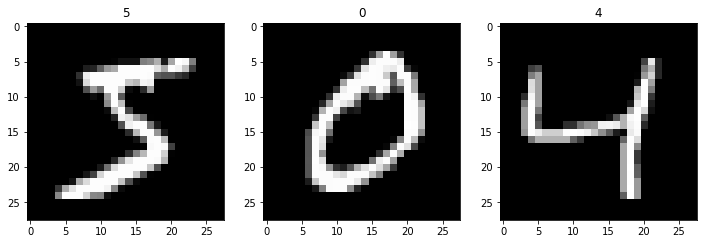

In [91]:
plt.figure(figsize=(12,4))

for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(training[i][0][0,:,:], cmap="gray")
    plt.title(str(training[i][1]))
    
image, label = training[0]
image.shape

The shape of each image is `[1, 28, 28]`, which means: 1 color channel (grayscale), 28 pixels height, 28 pixels width. This format is known as **CHW (channels, height, width)**. PyTorch supports the CHW structure, however, it suggests that HWC (channels last) normally performs better, which can be very important for larger models using larger images.

In [4]:
# Composition of the dataset
print(len(training.data), len(training.targets), len(testing.data), len(testing.targets))
print(training.classes)


60000 60000 10000 10000
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


Our dataset has 60000 training images and 10000 testing images, both with their corresponding labels and ten possible labels. 

## Model loading and batching

For loading large datasets of images in PyTorch models, we can use the `torch.utils.data.DataLoader`. What this does is splitting the data into chunks or batches so the model iterates on the batches and not on the whole data all at once. A typical (and recommended) batch size is 32 

*Friends dont let friends use minibatches larger than 32* - Yann LeCun

In [5]:
BatchSize = 32

train_dataloader = DataLoader(training, # Which data we are loading
                              batch_size = BatchSize, # Batch size
                              shuffle = True) # Image shuffling every epoch

# Shuffling is commonly done for the training data, not necessarily for the testing data

test_dataloader = DataLoader(testing, batch_size = BatchSize, shuffle = False)

# Check Structure of the dataloaders
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BatchSize}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BatchSize}")

train_features_batch, train_labels_batch = next(iter(train_dataloader))

# Check the structure of the data and labels
print(train_features_batch.shape, train_labels_batch.shape)

Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32
torch.Size([32, 1, 28, 28]) torch.Size([32])


(-0.5, 27.5, 27.5, -0.5)

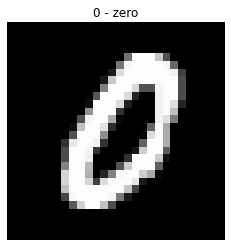

In [6]:
# We can show a sample to check

torch.manual_seed(35)
rand_id = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[rand_id], train_labels_batch[rand_id]
plt.imshow(img.squeeze(),cmap='gray')
plt.title(training.classes[label])
plt.axis('off')

We now have the information to build our model. Neural Networks that classify images typically start with a **flatten** layer (`nn.Flatten`) which transforms images into 1-dimensional tensors (vectors), where each pixel of the flattened image becomes a hidden unit. Because we are working with 28 by 28 images, our flattened layer will have 784 starting hidden units. 

As you can see from seeing a number, data doesn't appear to be exactly linear. And in most models that work with images, this holds true and the ReLU activation is a very common activation. 

We can then create our model class. 

In [7]:
class NumberModel(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, hidden_units: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.ReLU(),
            nn.Linear(in_features=input_shape,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_shape))
    
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [8]:
# We can start: setting up the accuracy function, initialize the model and set up loss and optimizer

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

torch.manual_seed(33)

model_0 = NumberModel(input_shape=784,
                      output_shape=len(training.classes),
                      hidden_units=50)

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)


model_0.to(device)

NumberModel(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): ReLU()
    (2): Linear(in_features=784, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [9]:
# Typically, Deep Learning models are computationally intensive and take their time to be trained. Setting up a timer function can be a good idea to compare model performance in different devices and by tuning some parameters

from timeit import default_timer as timer 
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [10]:
# Build train and test loop

from tqdm.auto import tqdm # Progress bar

torch.manual_seed(33)
Train_time_cpu = timer()

epochs = 10

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
        
    ## Training
    
    train_loss = 0
    ### Because we have our data split into batches, we need to iterate through the batches
    
    for batch, (X,y) in enumerate(train_dataloader):
        model_0.train()
        
        # Forward pass
        y_pred = model_0(X)
        
        # Per-batch loss
        loss = loss_fn(y_pred,y)
        train_loss += loss
        
        # Optimizer zero grad
        optimizer.zero_grad()
        
        # Backward propagation
        loss.backward()
        
        # Optimizer step
        optimizer.step()
        
        # Print the number of seen samples
        if batch % 400 == 0:
            print(f"Looked at {batch*len(X)}/{len(train_dataloader.dataset)} samples") 
    
    # Divide train loss by length of dataloader (average loss per batch per epoch) 
    train_loss /= len(train_dataloader)
    
    ## Testing
    test_loss, test_acc = 0, 0
    model_0.eval()
    
    with torch.inference_mode():
        
        # Initialize iteration
        for X,y in test_dataloader:
            
            # Forward pass
            test_pred = model_0(X)
            
            # Calculate cummulative loss
            test_loss += loss_fn(test_pred,y)
            
            # Calculate cummulative accuracy
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
            
        # Calculation of test metrics
        ## Divide total loss by length of test dataloader
        test_loss /= len(test_dataloader)
        
        ## Do the same for the accuracy
        test_acc /= len(test_dataloader)
        
    # Print out what's happening every 10 epochs        
    print(f"Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

Train_time_end_cpu = timer()
total_train_time_model_0 = print_train_time(start=Train_time_cpu, 
                                           end=Train_time_end_cpu,
                                           device=str(next(model_0.parameters()).device))
            
            
    

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.38350 | Test loss: 0.17528 | Test accuracy: 94.79%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.15389 | Test loss: 0.13343 | Test accuracy: 95.92%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.11452 | Test loss: 0.12465 | Test accuracy: 96.13%

Epoch: 3
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.09048 | Test loss: 0.09600 | Test accuracy: 97.06%

Epoch: 4
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 2

We can see that gradually our model increases in accuracy. As more and more models are built, it's a good option to build functions that automate certain processes for comparisons.

For example, we can build a function to extract the loss and accuracy of our model:


In [11]:
torch.manual_seed(33)

def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
    
    loss, acc = 0, 0
    model.eval()
    
    with torch.inference_mode():
        
        for X,y in data_loader:
            
            X, y = X.to(device), y.to(device)
            
            # Predict using the model
            y_pred = model(X)
            
            # Calculate loss and accuracy
            loss += loss_fn(y_pred,y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
            
        # Scale to find averages
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"Model name":model.__class__.__name__,
           "Model loss": loss.item(),
           "Model accuracy": acc}

In [12]:
# Calculate model results on test dataset

model_0_results = eval_model(model=model_0, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn,device=device)
model_0_results

{'Model name': 'NumberModel',
 'Model loss': 0.0966479703783989,
 'Model accuracy': 97.27436102236422}

Another option is to build functions that perform the training and testing steps. Here we'll build functions based on our standard train-test loops

In [13]:
def train_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              accuracy_fn,
              device: torch.device = device):
    
    train_loss, train_acc = 0,0
    model.to(device)
    
    for batch, (X,y) in enumerate(data_loader):
        # Send data to device
        X, y = X.to(device), y.to(device)
        
        # Forward pass
        y_pred = model(X)
        
        # Per-batch loss and accuracy
        loss = loss_fn(y_pred,y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        
        # Optimizer zero grad
        optimizer.zero_grad()
        
        # Backward propagation
        loss.backward()
        
        # Optimizer step
        optimizer.step()
        
    # Divide train loss and accuracy by length of dataloader (average loss/accuracy per batch per epoch) 
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    
    print(f"Training loss: {train_loss:.5f} | Training accuracy: {train_acc:.2f}%\n")
    
    
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    
    test_loss, test_acc = 0,0
    model.to(device)
    model.eval()
    
    with torch.inference_mode():
        
        for X,y in data_loader:
            
            # Forward pass
            test_pred = model(X)
            
            # Cumulative loss
            test_loss += loss_fn(test_pred,y)
            
            # Cummulative accuracy
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
            
        # Divide train loss and accuracy by length of dataloader (average loss/accuracy per batch per epoch) 
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        
        print(f"Testing loss: {test_loss:.5f} | Testing accuracy: {test_acc:.2f}%\n")

In [14]:
torch.manual_seed(55)

#train_start_gpu = timer()

epochs = 5

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n--------")
    train_step(model = model_0,
              data_loader = train_dataloader,
              loss_fn = loss_fn,
              optimizer = optimizer,
              accuracy_fn = accuracy_fn, device=device)
    
    test_step(model = model_0,
              data_loader = test_dataloader,
              loss_fn = loss_fn,
              accuracy_fn = accuracy_fn, device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
--------
Training loss: 0.03802 | Training accuracy: 98.76%

Testing loss: 0.10775 | Testing accuracy: 97.14%

Epoch: 1
--------
Training loss: 0.03379 | Training accuracy: 98.86%

Testing loss: 0.09446 | Testing accuracy: 97.40%

Epoch: 2
--------
Training loss: 0.03043 | Training accuracy: 99.02%

Testing loss: 0.08854 | Testing accuracy: 97.47%

Epoch: 3
--------
Training loss: 0.02925 | Training accuracy: 99.02%

Testing loss: 0.09256 | Testing accuracy: 97.76%

Epoch: 4
--------
Training loss: 0.02697 | Training accuracy: 99.13%

Testing loss: 0.10165 | Testing accuracy: 97.39%



## Building a Convolutional Neural Network (CNN)

CNNs are a type of network that's well optimized for finding patterns in image data. A detailes explanation can be found in the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/).

A key aspect of CNNs is their architecture. As well as having input and output layers, they are also built with:

- Convolutional layers
- Activation layers
- Pooling layers

### Convolutional layers

### Activation layers
Layers where activation functions (typically ReLU or Softmax)


### Pooling layers
There are many types of pooling layers in different CNN architectures. Their purpose is to gradually decrease the spatial extent of the network, which reduces the parameters and overall computation of the network. 

In [15]:
# Create a CNN for our number image data

class NumberModel_CNN(nn.Module):
    
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    
    def __init__(self,input_shape: int, output_shape: int, hidden_units: int):
        super().__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # How big is the square that goes over the image?
                      stride=1, # Default value
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3, 
                      stride=1, 
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(hidden_units,hidden_units,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units,hidden_units,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
            # These in_features come from the compressing of the images and shape change in the pooling layers
        )
        
    def forward(self, x: torch.tensor):
        x = self.block1(x)
        x = self.block2(x)
        x = self.classifier(x)
        
        return x
        # Alternatively
        # return self.classifier(self.block2(self.block1(x)))

In [16]:
torch.manual_seed(33)
model_2 = NumberModel_CNN(input_shape=1, 
    hidden_units=10, 
    output_shape=len(training.classes)).to(device)
model_2

NumberModel_CNN(
  (block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

Now that we have built our model, we can perform our train and test loop using our previously defined functions

In [34]:
torch.manual_seed(33)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),lr=0.1)

train_CNN_model2_start = timer()

# Train and test model 
epochs = 5
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    
    train_step(data_loader=train_dataloader,
               model=model_2,
               loss_fn=loss_fn,
               accuracy_fn=accuracy_fn,
               optimizer=optimizer,
               device=device)
    
    test_step(data_loader=test_dataloader,
               model=model_2,
               loss_fn=loss_fn,
               accuracy_fn=accuracy_fn,
               device=device)

train_CNN_model_end2 = timer()
total_train_time_model_2 = print_train_time(start=train_CNN_model2_start,
                                           end=train_CNN_model_end2,
                                           device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
---------
Training loss: 0.05089 | Training accuracy: 98.46%

Testing loss: 0.04426 | Testing accuracy: 98.52%

Epoch: 1
---------
Training loss: 0.04517 | Training accuracy: 98.61%

Testing loss: 0.04090 | Testing accuracy: 98.61%

Epoch: 2
---------
Training loss: 0.04025 | Training accuracy: 98.77%

Testing loss: 0.04219 | Testing accuracy: 98.66%

Epoch: 3
---------
Training loss: 0.03750 | Training accuracy: 98.86%

Testing loss: 0.04349 | Testing accuracy: 98.55%

Epoch: 4
---------
Training loss: 0.03424 | Training accuracy: 98.92%

Testing loss: 0.03475 | Testing accuracy: 98.78%

Train time on cpu: 90.487 seconds


In [35]:
# Then evaluate the model

model_2_results = eval_model(data_loader=test_dataloader,model=model_2,accuracy_fn=accuracy_fn,loss_fn=loss_fn,device=device)
model_2_results

{'Model name': 'NumberModel_CNN',
 'Model loss': 0.03474917262792587,
 'Model accuracy': 98.78194888178913}

## Compare models

As you train more and more models with different parameters and netowrk architectures, it becomes good practice to compare the performance of the models in order to choose the one that performs better (speed and/or accuracy). Options are:
- Comparing the loss, accuracy and train time values of the models
- Evaluating predictions in randomly generated data
- Confusion matrices

In [36]:
# Model comparison

import pandas as pd

model_results = pd.DataFrame([model_0_results,model_2_results])

model_results["training time"] = [total_train_time_model_0, total_train_time_model_2]

model_results

,Model name,Model loss,Model accuracy,training time
0,NumberModel,0.096648,97.274361,97.427669
1,NumberModel_CNN,0.034749,98.781949,90.486741


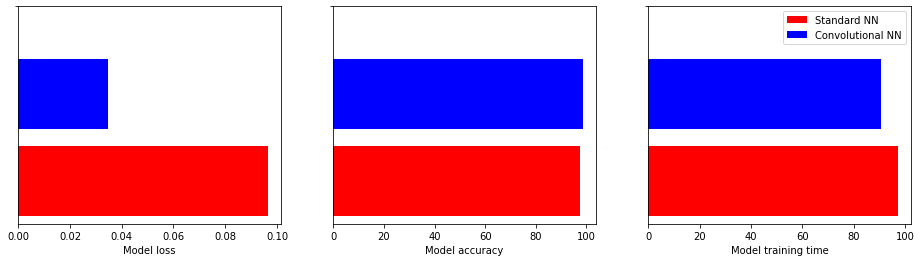

In [37]:
# Visualize the results

plt.figure(figsize=(16,4))

plt.subplot(1,3,1)
plt.barh(model_results["Model name"],model_results["Model loss"], color=['red','blue'])
plt.xlabel("Model loss")
plt.yticks("")

plt.subplot(1,3,2)
plt.barh(model_results["Model name"],model_results["Model accuracy"], color=['red','blue'])
plt.xlabel("Model accuracy")
plt.yticks("")

plt.subplot(1,3,3)
plt.barh(model_results["Model name"],model_results["training time"], color=['red','blue'],label=['Standard NN','Convolutional NN'])
plt.xlabel("Model training time")
plt.yticks("")
plt.legend()

In [77]:
# Make and evaluate random predictions

def make_predict(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_prob_list = []
    model.eval()
    
    with torch.inference_mode():
        for sample in data:
            # Sample preparation
            sample = torch.unsqueeze(sample, dim=0).to(device)
            
            # Forward pass (logits output)
            pred_logit = model(sample)
            
            # Transform to probabilities
            pred_probs = torch.softmax(pred_logit.squeeze(),dim=0)
            
            #
            pred_prob_list.append(pred_probs)
          
    # Stack the probabilites to turn list into a tensor
    return torch.stack(pred_prob_list)
            

In [59]:
# Random sampling

import random

random.seed(33)
test_samples = []
test_labels = []

for sample, label in random.sample(list(testing), k=9):
    test_samples.append(sample)
    test_labels.append(label)

In [79]:
# Make predictions using our new function

prediction_probabilities = make_predict(model=model_2,data=test_samples,device=device)

prediction_probabilities[:2]

tensor([[3.5004e-16, 4.9159e-10, 3.4921e-09, 3.0620e-10, 9.9999e-01, 1.2501e-09,
         5.1601e-13, 1.6207e-08, 1.8708e-08, 1.3401e-05],
        [2.1428e-07, 3.9746e-07, 2.4224e-07, 1.2978e-05, 3.6522e-06, 1.2880e-06,
         4.9514e-11, 2.0922e-03, 4.1802e-05, 9.9785e-01]])

In [81]:
# However it's better to transform it to the actual labels

prediction_classes = prediction_probabilities.argmax(dim=1)
prediction_classes

tensor([4, 9, 9, 8, 1, 7, 9, 7, 4])

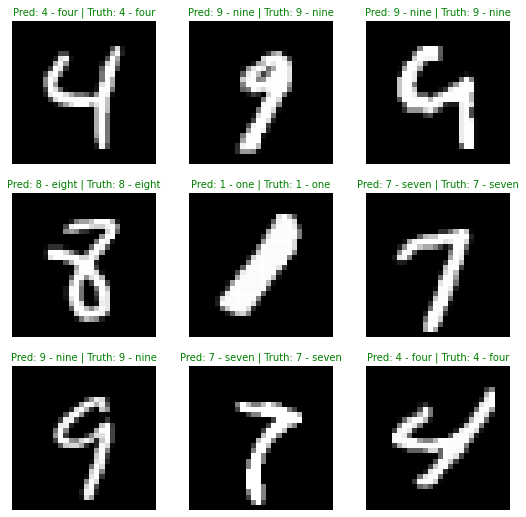

In [94]:
# Plot the predictions

plt.figure(figsize=(9,9))

nrow, ncol = 3, 3

for i, sample in enumerate(test_samples):
    
    plt.subplot(nrow,ncol,i+1)
    
    plt.imshow(sample.squeeze(),cmap='gray')
    plt.axis('off')
    
    pred_label = class_names[prediction_classes[i]]
    true_label = class_names[test_labels[i]]
    
    title_label = f"Pred: {pred_label} | Truth: {true_label}"
    
    if pred_label == true_label:
        plt.title(title_label, fontsize=10, c='g')
    else:
        plt.title(title_label, fontsize=10, c='r')

## Confusion matrix

A confusion matrix shows how many times labels were classified correctly and incorrectly. The diagonal of the matrix is the correct classifications of the model, while the rest shows the incorrect ones. This can help identify hard classify labels, and solve potential issues with ground-truth labels.

To build a confusion matrix we follow these steps:

1. Make predictions with a trained model
2. Make the confusion matrix using `torchmetrics.ConfusionMatrix`
3. Plot the matrix. For this use `mlxtend.plotting.plot_confusion_matrix()`

In [95]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.22.0


In [98]:
# 1. Predictions

y_preds = []
model_2.eval()

with torch.inference_mode():
    
    for X,y in tqdm(test_dataloader, desc="predicting"):
        
        X, y = X.to(device), y.to(device)
        
        y_logits = model_2(X)
        
        y_pred = torch.softmax(y_logits,dim=1).argmax(dim=1)
        y_preds.append(y_pred)

y_preds_tensor = torch.cat(y_preds)

predicting:   0%|          | 0/313 [00:00<?, ?it/s]

In [102]:
# 2. Make the confusion matrix

from torchmetrics import ConfusionMatrix

ConfMat = ConfusionMatrix(num_classes = len(class_names), task='multiclass')

ConfMat_tensor = ConfMat(preds=y_preds_tensor, target=testing.targets)

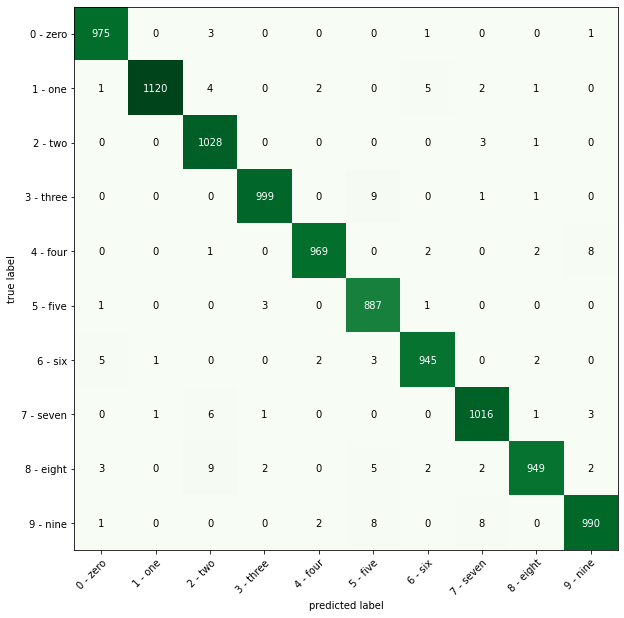

In [109]:
# 3. Plot the matrix

from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(
    conf_mat = ConfMat_tensor.numpy(),
    class_names=class_names,
    cmap='Greens',
    figsize=(10,10))

In [111]:
# Finally, let's save our CNN model

from pathlib import Path

Mods_Path = Path("models")

Mod_Name = "CNN_MNIST_Numbers_model.pth" # .pth and .pt are standard PyTorch file extensions
Mod_Saving_Path = Mods_Path / Mod_Name

print(f"Saving path is {Mod_Saving_Path}")

# Save the model state dict
torch.save(obj = model_2.state_dict(), f = Mod_Saving_Path)

Saving path is models/CNN_MNIST_Numbers_model.pth
